In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy import stats
import sys, traceback
import shap

In [2]:
# Standardization module
def stand(df1,df2):
    x1=df1.values
    scalar=preprocessing.StandardScaler()
    scalar.fit(x1)
    x2=df2.values
    name2=df2.columns
    x_std=scalar.transform(x2)
    x_std=pd.DataFrame(x_std)     
    x_std.columns=name2
    return(x_std)

In [3]:
# READ DATASET
data = pd.read_csv('fatigue_data.csv')   
df=pd.DataFrame(data)

# df_impute = df.replace(0,df.mean())      ## imputation of missing data with mean values


In [4]:
# Remove outliers from data set

df=pd.DataFrame(data)                                      
z0=stats.zscore(df)
z1=np.abs(z0<3)                              
df1=df[z1.all(axis=1)]                      
df1=(df1)

In [5]:
Y_org = df1.iloc[:,1]                                
Y = np.log10(Y_org) 
X_org = df1.iloc[:,2:]                              

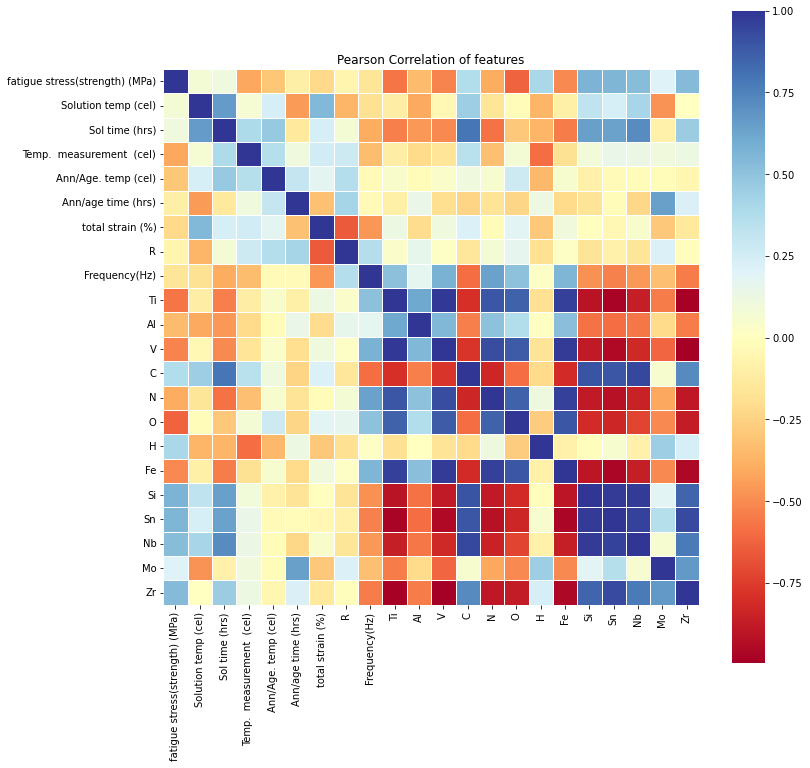

In [6]:
# PCC correlation between features
c=X_org
str_list = []                                 
for colname, colvalue in c.iteritems():
    if type(colvalue[1]) == str:
          str_list.append(colname)
         
num_list = c.columns.difference(str_list) 

a1 = c[num_list]
f, ax = plt.subplots(figsize=(12,12))
plt.title('Pearson Correlation of features')

sns.heatmap(a1.astype(float).corr(),linewidths=1.0,vmax=1.0,square=True, 
            cmap="RdYlBu", linecolor='white', annot=False)
sns.set(font_scale=1.0)
plt.xticks(fontsize="10",rotation=90)
plt.yticks(rotation=0, fontsize="10", va="center")

plt.show()
corr=a1.corr()

In [7]:
# Feature selection using PCC thresold 
threshold = 0.80   # threshold value
corr = a1.corr()
X_fin=a1.copy()
col_corr = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if (corr.iloc[i, j] >= threshold or corr.iloc[i,j]<= -threshold):
            col2 = corr.columns[i] # getting the name of column
            col_corr.add(col2)
            if col2 in X_fin.columns:
                del X_fin[col2]

print("-------After removing highly correlated features------------------------------")
print(X_fin.columns)     # final featue set

-------After removing highly correlated features------------------------------
Index(['fatigue stress(strength) (MPa)', 'Solution temp (cel)',
       'Sol time (hrs)', 'Temp.  measurement  (cel)', 'Ann/Age. temp (cel)',
       'Ann/age time (hrs)', 'total strain (%)', 'R', 'Frequency(Hz)', 'Ti',
       'Al', 'C', 'H', 'Mo'],
      dtype='object')


In [8]:
# Training of ML model over 3000 random trials
start= 2585           
end= 2585         

for random in range(start,end+1,1):
    X_train,X_test,Y_train,Y_test = train_test_split(X_fin,Y,test_size=0.1,random_state=random)
    
    X_test=stand(X_train,X_test)
    X_train=stand(X_train,X_train) 
                                                    

    

In [9]:
    reg = GradientBoostingRegressor(loss='ls', learning_rate=0.01, 
                            n_estimators=1600, subsample=1.0, max_depth=3,
                            criterion='friedman_mse', min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            random_state=random)
             
     
    reg.fit(X_train,Y_train)
        
    predicted_test=reg.predict(X_test)
    predicted_train=reg.predict(X_train)
    
    R2_test=metrics.r2_score(Y_test,predicted_test)
    R2_train=metrics.r2_score(Y_train,predicted_train)
    rmse_test=np.sqrt(metrics.mean_squared_error(Y_test,predicted_test))
    rmse_train=np.sqrt(metrics.mean_squared_error(Y_train,predicted_train))

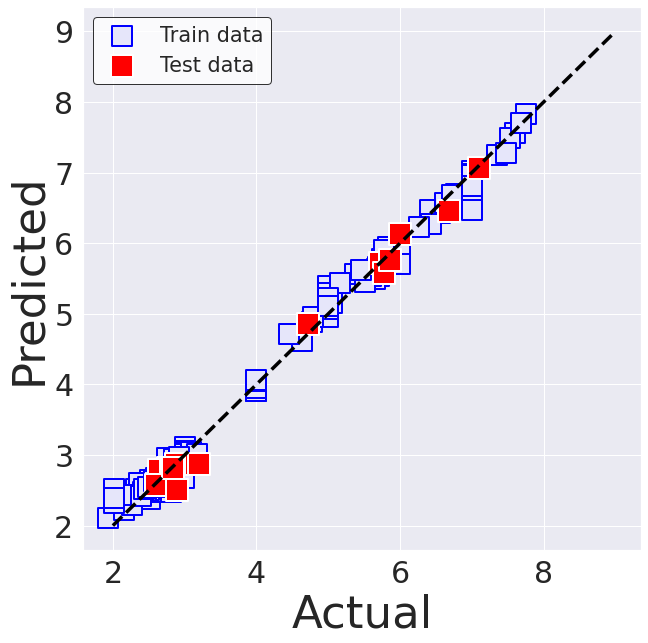

In [10]:
    fig,ax=plt.subplots(figsize=(10,10))
    plt.scatter(Y_train, reg.predict(X_train),s = 400, marker='s',linewidth=2,edgecolors="blue", label = 'Train data',color = "lavender")  #, marker='o',color = "grey", edgecolors="white", linewidth='2', s = 600, ) 
    plt.scatter( Y_test, reg.predict(X_test),s = 500, marker='s', linewidth=2,edgecolors="white",label = 'Test data',color = "red")  #,color = "navy", edgecolors="white",linewidth='1', s = 600, label = 'Test data') 
    xl=[2,3,4,5,6,7,8,9]
    yl=[2,3,4,5,6,7,8,9]
    plt.plot(yl,xl,linestyle='dashed',color='black', linewidth=3.5) 
    plt.legend(loc = 'upper left',fontsize='xx-large',facecolor='w',edgecolor='black') 
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.xlabel('Actual',fontsize=45)
    plt.ylabel("Predicted",fontsize=45)
    plt.show()

In [11]:
print ("Output of model")
print ("R2 train/test =  ",R2_train,"/",R2_test)
print ("RMSE train/test =  ",rmse_train,"/",rmse_test)

Output of model
R2 train/test =   0.9926120035028149 / 0.9891223275506971
RMSE train/test =   0.14959549660319185 / 0.165174584494554


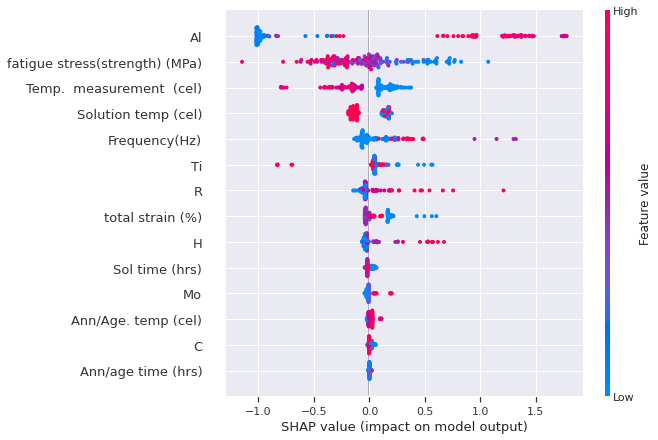

In [12]:
# SHAP feature importances

shap_values = shap.TreeExplainer(reg).shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, show=False)       ##--- summary plot

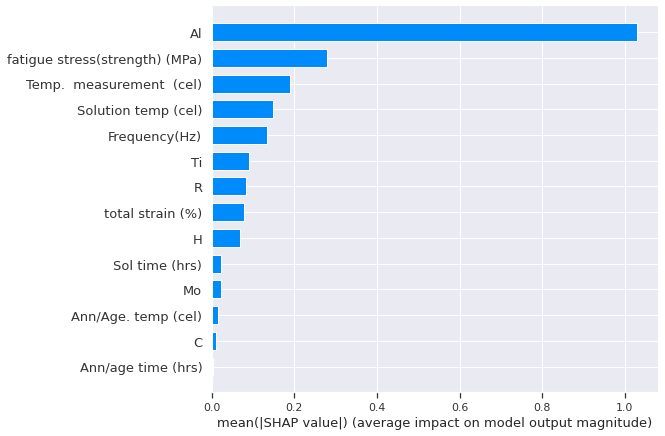

In [13]:
shap.summary_plot(shap_values, X_train, plot_type="bar")  ##----bar plot  


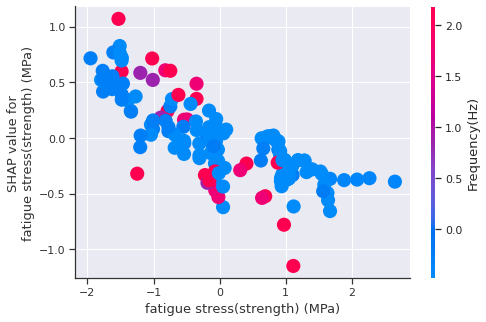

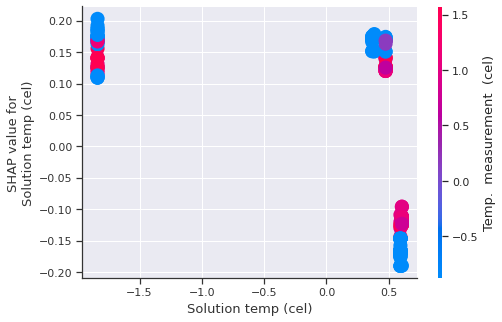

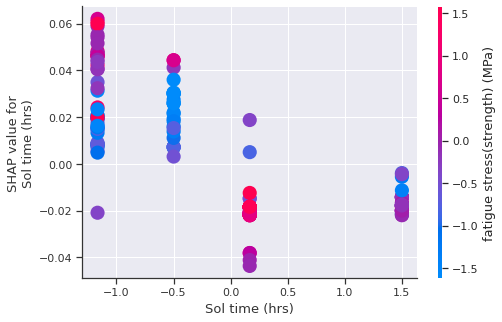

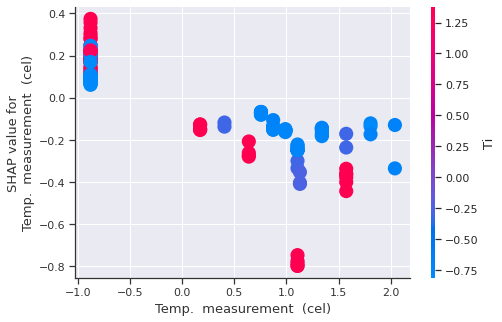

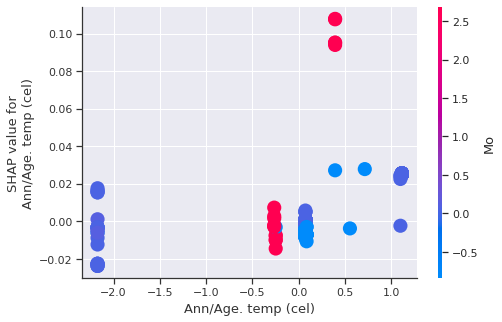

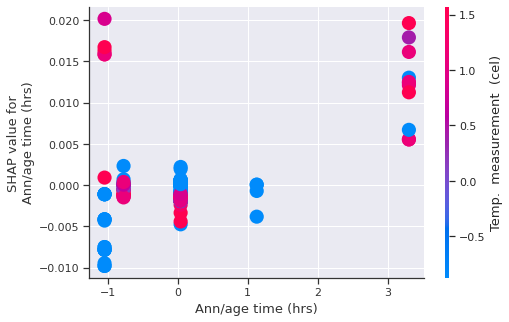

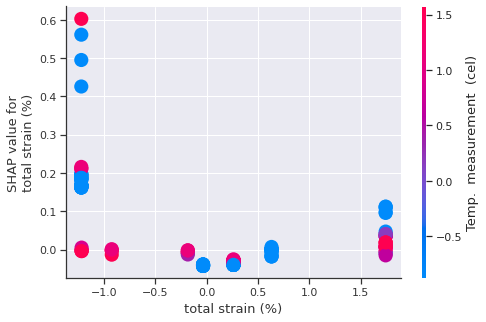

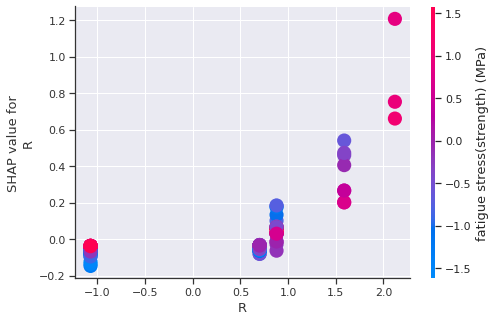

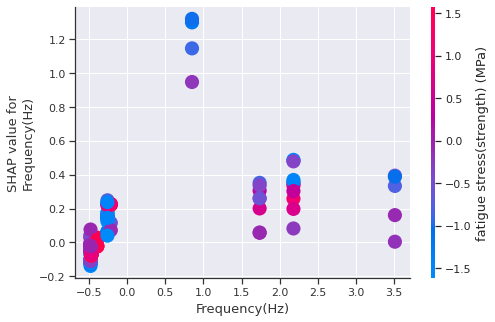

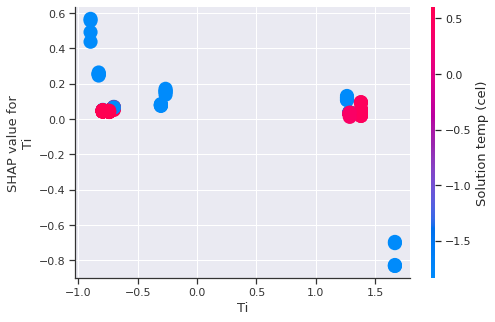

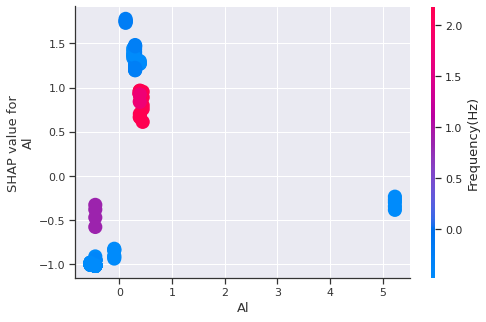

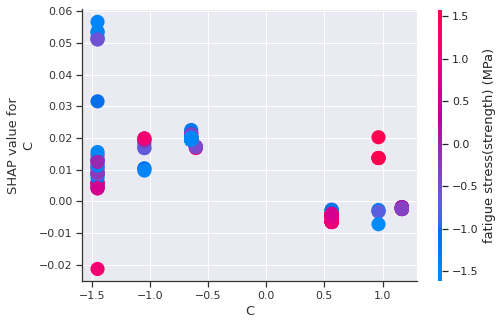

In [14]:
shap_values = shap.TreeExplainer(reg).shap_values(X_train)
for i in range(12):
    shap.dependence_plot(i, shap_values, X_train,show=False,
                      interaction_index='auto', dot_size=200)    ## interaction_index=any features or 'auto'

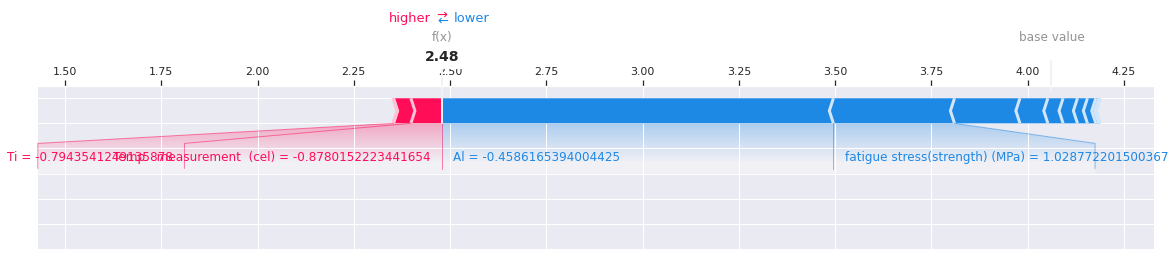

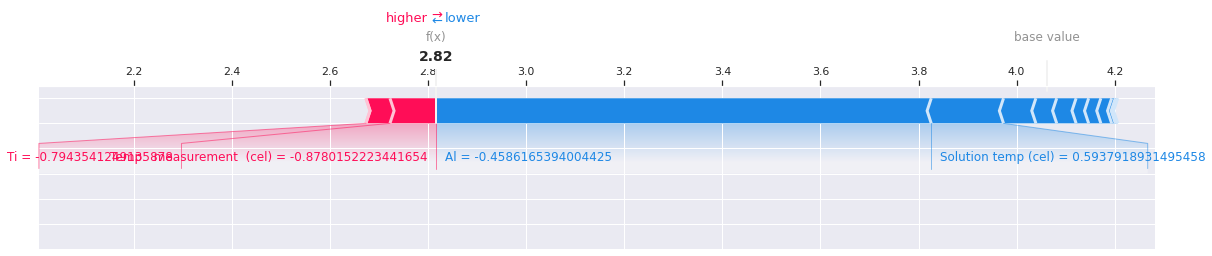

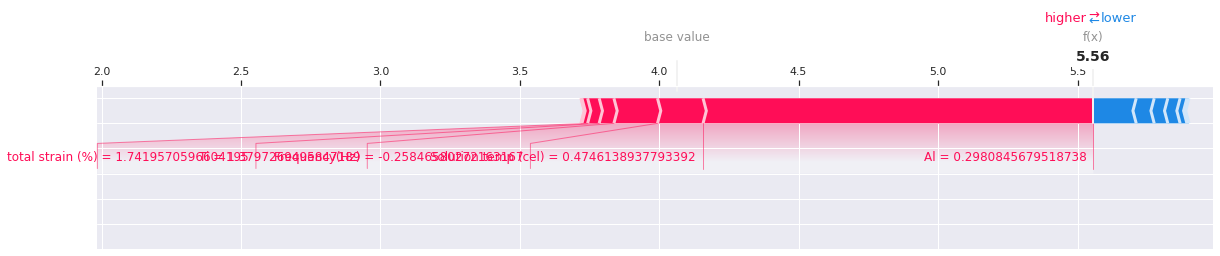

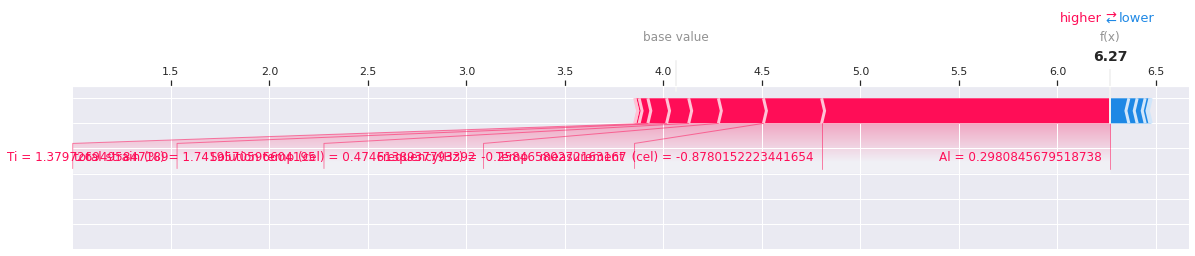

In [16]:
explainer = shap.TreeExplainer(reg)
shap_values = shap.TreeExplainer(reg).shap_values(X_train)
list1=[4,44,31,23]
for i in list1:                         
    shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], 
                feature_names=X_train.columns, matplotlib=True)     ##,show=False)